In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, ConcatDataset


In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# train_data = pd.read_csv("../data/preprocessed/preprocessed_train.csv")
# test_data = pd.read_csv("../data/preprocessed/preprocessed_test.csv")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [ ]:
def driver_dataframe(df, path_order, driver):
    """
    Extracts and processes the DataFrame for a specific driver and path order.

    Parameters:
    df (DataFrame): The original DataFrame.
    path_order (int): The path order identifier.
    driver (str): The driver class identifier.

    Returns:
    DataFrame: Processed DataFrame for the specified driver and path order.
    """
    driver_df = df[df['PathOrder'] == path_order]
    driver_df = driver_df[driver_df['Class'] == driver]
    driver_df = driver_df.sort_values(by='Time(s)')
    driver_df.drop(columns=['Class', 'PathOrder'], inplace=True)
    driver_df = driver_df.groupby('Time(s)').mean()
    driver_df['Time(s)'] = driver_df.index
    return driver_df

In [ ]:
def split_dataset(df, train_ratio=0.8, random_seed=123):
    """
    Splits the dataset into training and testing sets based on driver and path order.

    Parameters:
    df (DataFrame): The original DataFrame.
    train_ratio (float): Ratio of the dataset to be used for training. Default is 0.8.
    random_seed (int): Seed for random number generator. Default is 123.

    Returns:
    DataFrame: Training set.
    DataFrame: Testing set.
    """

    # set a random seed
    np.random.seed(random_seed)

    # create a copy of dataframe
    df_copy = df.copy()

    # Lists to hold individual DataFrames
    df_train = []
    df_test = []

    # Nested loops to process each path and driver
    for path in df_copy['PathOrder'].unique():
        for driver in df_copy['Class'].unique():
            driver_df = driver_dataframe(df_copy, path, driver)
            driver_df['PathOrder'] = path  # Add PathOrder
            driver_df['Class'] = driver    # Add Class

            # Calculate the index to split the data
            split_index = int(train_ratio * len(driver_df))

            # Split the data
            df_train_split = driver_df.iloc[:split_index]
            df_test_split = driver_df.iloc[split_index:]

            # Append the data to df_train and df_test lists
            df_train.append(df_train_split)
            df_test.append(df_test_split)

    # Concatenate the DataFrames
    df_train = pd.concat(df_train, ignore_index=True)
    df_test = pd.concat(df_test, ignore_index=True)

    return df_train, df_test

In [ ]:
selected_features = ['Engine_soacking_time', 'Long_Term_Fuel_Trim_Bank1', 'Engine_coolant_temperature.1',
 'Torque_of_friction', 'Activation_of_Air_compressor', 'Intake_air_pressure', 'PathOrder', 'Accelerator_Pedal_value',
 'Master_cylinder_pressure', 'Vehicle_speed','Engine_coolant_temperature', 'Maximum_indicated_engine_torque',
 'Throttle_position_signal', 'Current_Gear', 'Calculated_LOAD_value', 'Engine_torque_after_correction',
 'Engine_torque', 'Class', 'Time(s)']

In [ ]:
data = pd.read_csv("/content/drive/My Drive/graduation/Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv")

In [ ]:
selected_df = data[selected_features]

In [ ]:
selected_df.head()

,Engine_soacking_time,Long_Term_Fuel_Trim_Bank1,Engine_coolant_temperature.1,Torque_of_friction,Activation_of_Air_compressor,Intake_air_pressure,PathOrder,Accelerator_Pedal_value,Master_cylinder_pressure,Vehicle_speed,Engine_coolant_temperature,Maximum_indicated_engine_torque,Throttle_position_signal,Current_Gear,Calculated_LOAD_value,Engine_torque_after_correction,Engine_torque,Class,Time(s)
0,3,-0.8,87,9.0,0,33,1,0.0,325.5,0,95,58.2,5.2,0,23.9,5.5,5.5,A,1
1,3,-0.8,87,7.8,0,40,1,0.0,0.9,0,95,53.9,6.1,0,30.6,7.0,7.0,A,2
2,3,-0.8,87,7.4,0,41,1,0.0,0.9,0,95,53.1,5.2,0,31.8,7.0,7.0,A,3
3,3,-0.8,87,6.6,0,38,1,0.0,0.9,0,95,53.1,4.7,0,29.0,7.0,7.0,A,4
4,3,-0.8,87,11.3,1,40,1,0.0,0.9,0,95,53.5,5.7,0,30.2,8.2,8.2,A,5


In [ ]:
# df_train, df_test = split_dataset(selected_df, 0.8)

In [ ]:

def driver_dataframe_using_window_size(df, path_order, driver, window_size=60):
    """
    Extracts and processes the DataFrame for a specific driver and path order,
    and calculates rolling statistics with the specified window size.

    Parameters:
    df (DataFrame): The original DataFrame.
    path_order (int): The path order identifier.
    driver (str): The driver class identifier.
    window_size (int): The size of the rolling window.

    Returns:
    DataFrame: Processed DataFrame for the specified driver and path order with
               rolling statistics concatenated to the original features.
    """

    # Filter the DataFrame for the specific driver and path order
    driver_df = df[df['PathOrder'] == path_order]
    driver_df = driver_df[driver_df['Class'] == driver]


    # Drop the 'Class' and 'PathOrder' columns
    time = driver_df['Time(s)']
    driver_df.drop(columns=['Class', 'PathOrder', 'Time(s)'], inplace=True)


    # Calculate rolling statistics
    rolling_mean = driver_df.rolling(window=window_size).mean().add_suffix('_mean')
    rolling_median = driver_df.rolling(window=window_size).median().add_suffix('_median')
    rolling_std = driver_df.rolling(window=window_size).std().add_suffix('_std')
#     rolling_var = driver_df.rolling(window=window_size).var().add_suffix('_var')
#     rolling_min = driver_df.rolling(window=window_size).min().add_suffix('_min')
#     rolling_max = driver_df.rolling(window=window_size).max().add_suffix('_max')

    # Concatenate the original features with the rolling statistics
    # , rolling_var, rolling_min, rolling_max
    driver_df = pd.concat([driver_df, rolling_mean, rolling_median, rolling_std], axis=1)
    driver_df['Time(s)'] = time
    # Drop the first 'window_size' rows to make the concatenation match
    driver_df = driver_df.iloc[window_size-1:]

    return driver_df


In [ ]:
def prepare_all_drivers(df, random_seed=123):
    """
    Prepares the dataset by processing each driver's data and calculating rolling statistics for each feature.

    Parameters:
    df (DataFrame): The original DataFrame.
    random_seed (int): The seed for the random number generator (default is 123).

    Returns:
    DataFrame: Processed DataFrame with rolling statistics and necessary columns for all drivers.
    """

    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Create a copy of the original DataFrame to ensure the original data is not altered
    df_copy = df.copy()

    # List to hold individual DataFrames for each driver and path
    df_temp = []

    # Nested loops to process each path and driver
    for path in df_copy['PathOrder'].unique():
        for driver in df_copy['Class'].unique():
            # Process the DataFrame for the specific driver and path using window size
            driver_df = driver_dataframe_using_window_size(df_copy, path, driver)
            driver_df['PathOrder'] = path  # Add PathOrder column
            driver_df['Class'] = driver    # Add Class column

            # Append the processed DataFrame to the list
            df_temp.append(driver_df)

    # Concatenate all individual DataFrames into a single DataFrame
    all_drivers = pd.concat(df_temp, ignore_index=True)

    return all_drivers

In [ ]:
train_data = prepare_all_drivers(selected_df)

### Data Preprocessing

In [ ]:
deriver_d_path1 = train_data[(train_data['Class']=="D") & (train_data['PathOrder']==1) ]
deriver_d_path2 = train_data[(train_data['Class']=="D") & (train_data['PathOrder']==2) ]

In [ ]:
combined_data = pd.concat([deriver_d_path1, deriver_d_path2])



In [ ]:
deriver_d_path1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
deriver_d_path2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming deriver_d_path1 and deriver_d_path2 are numpy arrays or pandas DataFrames

# Initialize StandardScaler
scaler = MinMaxScaler()

# Fit and transform on deriver_d_path1
deriver_d_path1 = scaler.fit_transform(deriver_d_path1)

#Fit and Transform on deriver_d_path2
deriver_d_path2 = scaler.fit_transform(deriver_d_path2)


In [ ]:
one_deriver_data_path1 = deriver_d_path1
one_deriver_data_path2 = deriver_d_path2

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = np.array(data,dtype=float)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return self.data[idx:idx+self.sequence_length]

In [ ]:
sequence_length = 60
dataset_path1 = TimeSeriesDataset(one_deriver_data_path1, sequence_length)
dataset_path2 = TimeSeriesDataset(one_deriver_data_path2, sequence_length)
concatenated_data = ConcatDataset([dataset_path1, dataset_path2])
dataloader = DataLoader(concatenated_data, batch_size=32, shuffle=True)


In [ ]:
np.array(concatenated_data).shape

(13006, 60, 64)

In [ ]:
np.array(concatenated_data).shape

(13006, 60, 64)

### Modeling

In [ ]:
class ComplexTimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, sequence_lengt):
        super().__init__()

        # Define the CNN Encoder
        self.cnn_encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Define the LSTM Encoder
        self.lstm_encoder = nn.LSTM(input_size=64, hidden_size=latent_dim, batch_first=True)

        # Define the LSTM Decoder
        self.lstm_decoder = nn.LSTM(input_size=latent_dim, hidden_size=64, batch_first=True)

        # Define the CNN Decoder
        self.cnn_decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=input_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # Pass the input through the CNN Encoder
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, input_dim, sequence_length) for CNN
        x = self.cnn_encoder(x)
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, sequence_length, num_channels) for LSTM

        # Pass through the LSTM Encoder
        x, _ = self.lstm_encoder(x)

        # Pass through the LSTM Decoder
        x, _ = self.lstm_decoder(x)

        # Pass through the CNN Decoder
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, num_channels, sequence_length) for CNN
        x = self.cnn_decoder(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, sequence_length, input_dim)

        return x

In [ ]:
one_deriver_data_path1.shape

(6005, 64)

In [ ]:
input_dim = one_deriver_data_path1.shape[1]
latent_dim = 20
model = ComplexTimeSeriesAutoencoder(input_dim, latent_dim, sequence_length).to(device)

In [ ]:
num_epochs = 400
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch in dataloader:
        batch = batch.float().to(device)
        outputs = model(batch)
        loss = criterion(outputs, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

RuntimeError: cudnn RNN backward can only be called in training mode

In [ ]:
# torch.save(model.state_dict(), 'complex_time_series_autoencoder.pth')

In [ ]:
sequence_length = 60
dataset_path1 = TimeSeriesDataset(one_deriver_data_path1, sequence_length)
dataset_path2 = TimeSeriesDataset(one_deriver_data_path2, sequence_length)
concatenated_data = ConcatDataset([dataset_path1, dataset_path2])
dataloader = DataLoader(concatenated_data, batch_size=1, shuffle=True)


In [ ]:
def calculate_reconstruction_error(model, dataloader):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.float().to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch)
            errors.append(loss.item())
    return errors

validation_errors = calculate_reconstruction_error(model, dataloader)
# threshold = np.mean(validation_errors) + 3 * np.std(validation_errors)
# print(f'Reconstruction error threshold: {threshold:.4f}')

### Evaluate the model

In [ ]:
np.array(validation_errors).shape

(13006,)

In [ ]:
threshold = np.quantile(np.array(validation_errors), 0.95)

In [ ]:
threshold

0.004577435087412596

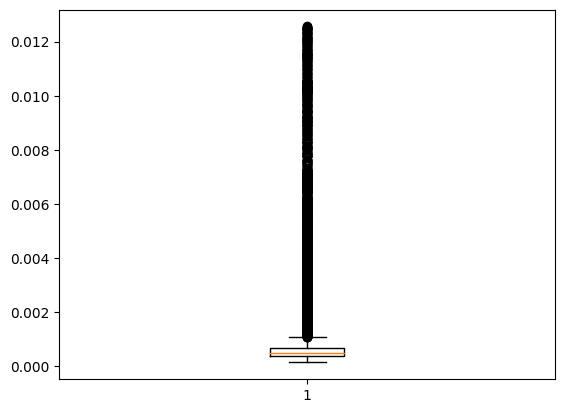

In [ ]:
plt.boxplot(validation_errors)
plt.show()

In [ ]:
def evalute_per_class():
    deriver_classes = selected_df['Class'].unique()
    for deriver_cls in deriver_classes:
        test_data_one_deriver_1 = train_data[(train_data['Class']==deriver_cls) & (train_data['PathOrder']==1) ]
        test_data_one_deriver_2 = train_data[(train_data['Class']==deriver_cls) & (train_data['PathOrder']==2) ]
        test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
        test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
        test_data_one_deriver_1 = scaler.fit_transform(test_data_one_deriver_1)
        test_data_one_deriver_2 = scaler.fit_transform(test_data_one_deriver_2)
        test_dataset_path2 = TimeSeriesDataset(test_data_one_deriver_2, sequence_length)
        test_dataset_path1 = TimeSeriesDataset(test_data_one_deriver_1, sequence_length)
        concatenated_data = ConcatDataset([test_dataset_path1, test_dataset_path2])
        test_dataloader = DataLoader(concatenated_data, batch_size=1, shuffle=True)
        anomalies_cnt = 0
        with torch.no_grad():
            for batch in test_dataloader:
                batch = batch.float().to(device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                if loss.item() > threshold:
                    anomalies_cnt += 1
        print(f"class {deriver_cls}  acc: {anomalies_cnt/(len(test_data_one_deriver_1)+len(test_data_one_deriver_2))}")


In [ ]:
evalute_per_class()

class A  acc: 0.983150800336984
class D  acc: 0.04959622124028645
class B  acc: 0.8951043464616351
class C  acc: 0.8161744784611217
class I  acc: 0.9725617685305592
class J  acc: 0.9863419075802413
class H  acc: 0.9522638803523868
class G  acc: 0.979522647138595
class F  acc: 0.9569487791444832
class E  acc: 0.9855734551574897
